# Monthly Cross-Section: Prediction

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data Import

### Load old dataframe

In [25]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

In [42]:
df_xs_predictions = pd.read_pickle('df_xs_predictions_monthly.pkl')

### Create new Dataframe

In [7]:
df_xs_predictions = pd.DataFrame(index=df_xs_estimates.index, columns = pd.MultiIndex.from_product([[],[],[]], names=['model','horizon','variable']))

In [8]:
df_xs_predictions[('data','data','return')] = df_xs_estimates[('data','return')]

## Make Predictions

In [53]:
hmm_name = 'HMM_full'

In [55]:
hmm_name = 'HMM_expand'

In [43]:
hmm_name = 'HMM_roll_40'

In [44]:
prediction_horizons = list(range(0,13))

### State Probabilities

In [45]:
%%time

for h in tqdm.trange(0,max(prediction_horizons)+1):
    p0 = []
    p1 = []
    for iObs in df_xs_predictions.index:
        if hmm_name == 'HMM_full':
            state_probabilities = [df_xs_estimates.at[iObs,(hmm_name,'filt_is_0')], df_xs_estimates.at[iObs,(hmm_name,'filt_is_1')]]
        else:
            state_probabilities = [df_xs_estimates.at[iObs,(hmm_name,'filt_prob_0')], df_xs_estimates.at[iObs,(hmm_name,'filt_prob_1')]]
        transition_matrix = [[df_xs_estimates.at[iObs,(hmm_name,'p00')], 1-df_xs_estimates.at[iObs,(hmm_name,'p00')]],
                             [df_xs_estimates.at[iObs,(hmm_name,'p10')], 1-df_xs_estimates.at[iObs,(hmm_name,'p10')]]]
        p0 += [clas.MarkovChain(transition_matrix, state_probabilities).iterate(h, return_state_vector=True)[0]]
        p1 += [clas.MarkovChain(transition_matrix, state_probabilities).iterate(h, return_state_vector=True)[1]]

    df_xs_predictions[(hmm_name,h,'p0')] = p0
    df_xs_predictions[(hmm_name,h,'p1')] = p1

#df_xs_predictions.to_pickle('df_xs_predictions_monthly.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:55<00:00, 13.12s/it]


Wall time: 2min 55s


### Distribution Moments

In [46]:
for h in prediction_horizons:
    df_xs_predictions[hmm_name,h,'mean'] = np.nan
    df_xs_predictions[hmm_name,h,'var'] = np.nan
    df_xs_predictions[hmm_name,h,'skew'] = np.nan
    df_xs_predictions[hmm_name,h,'kurt'] = np.nan
    df_xs_predictions[hmm_name,h,'std'] = np.nan
    df_xs_predictions[hmm_name,h,'entropy'] = np.nan
    
    df_xs_predictions[hmm_name,h,'cummean'] = np.nan
    df_xs_predictions[hmm_name,h,'cumvar'] = np.nan
    df_xs_predictions[hmm_name,h,'cumskew'] = np.nan
    df_xs_predictions[hmm_name,h,'cumkurt'] = np.nan
    df_xs_predictions[hmm_name,h,'cumstd'] = np.nan
    df_xs_predictions[hmm_name,h,'cumentropy'] = np.nan

In [56]:
%%time

count = 0

# iterate through each row
for iObs in tqdm.tqdm(df_xs_estimates.index[df_xs_estimates[hmm_name,'convergence']==True]):
    product = clas.ProductDistribution([])
    paths = [1]
    path_weights = [1]
    
    mus = [df_xs_estimates.at[iObs,(hmm_name,'mu_0')], df_xs_estimates.at[iObs,(hmm_name,'mu_1')]]
    sigmas = [df_xs_estimates.at[iObs,(hmm_name,'sigma2_0')]**0.5, df_xs_estimates.at[iObs,(hmm_name,'sigma2_1')]**0.5]
    component_indices = [1,2]
    
    # iterate through all forecast horizons
    for h in range(0,max(prediction_horizons)+1):
        # get component inputs for mixture distribution
        weights = [df_xs_predictions.at[iObs,(hmm_name,h,'p0')], df_xs_predictions.at[iObs,(hmm_name,h,'p1')]]
        
        paths = list(np.kron(paths,component_indices))
        path_weights = list(np.kron(path_weights,weights))
        
        # create forecast mixture distribution
        mixture = clas.MixtureDistribution([])
        for (m,s,p) in zip(mus,sigmas,weights):
            mixture.add_component((m,s,p))
        
        # calculate mixture moments and add central moments to factor distribution
        m,v,s,k = mixture.mvsk()
        ent = mixture.entropy()
        
        if h > 0:
            product.add_factor((m+1,v,s*v**1.5,(k+3)*v**2)) #central moments as inputs
        
        # save outputs
        if h in range(0,max(prediction_horizons)+1):
            # one-period distribution
            df_xs_predictions.at[iObs,(hmm_name,h,'mean')] = m
            df_xs_predictions.at[iObs,(hmm_name,h,'var')] = v
            df_xs_predictions.at[iObs,(hmm_name,h,'skew')] = s
            df_xs_predictions.at[iObs,(hmm_name,h,'kurt')] = k
            df_xs_predictions.at[iObs,(hmm_name,h,'std')] = mixture.std()
            df_xs_predictions.at[iObs,(hmm_name,h,'entropy')] = ent
            
            # cumulative distribution
            if h > 0:
                df_xs_predictions.at[iObs,(hmm_name,h,'cummean')] = product.mean()-1
                df_xs_predictions.at[iObs,(hmm_name,h,'cumvar')] = product.var()
                df_xs_predictions.at[iObs,(hmm_name,h,'cumskew')] = product.skew()
                df_xs_predictions.at[iObs,(hmm_name,h,'cumkurt')] = product.kurt()
                df_xs_predictions.at[iObs,(hmm_name,h,'cumstd')] = product.std()
                df_xs_predictions.at[iObs,(hmm_name,h,'cumentropy')] = calc.calculate_shannon_entropy(path_weights)
            else:
                df_xs_predictions.at[iObs,(hmm_name,h,'cummean')] = m
                df_xs_predictions.at[iObs,(hmm_name,h,'cumvar')] = v
                df_xs_predictions.at[iObs,(hmm_name,h,'cumskew')] = s
                df_xs_predictions.at[iObs,(hmm_name,h,'cumkurt')] = k
                df_xs_predictions.at[iObs,(hmm_name,h,'cumstd')] = mixture.std()
                df_xs_predictions.at[iObs,(hmm_name,h,'cumentropy')] = ent

#df_xs_predictions.to_pickle('df_xs_predictions_monthly.pkl')

100%|██████████████████████████████████████████████████████████████████████████| 40166/40166 [1:22:57<00:00,  8.08it/s]


Wall time: 1h 22min 57s


In [57]:
df_xs_predictions.to_pickle('df_xs_predictions_monthly.pkl')

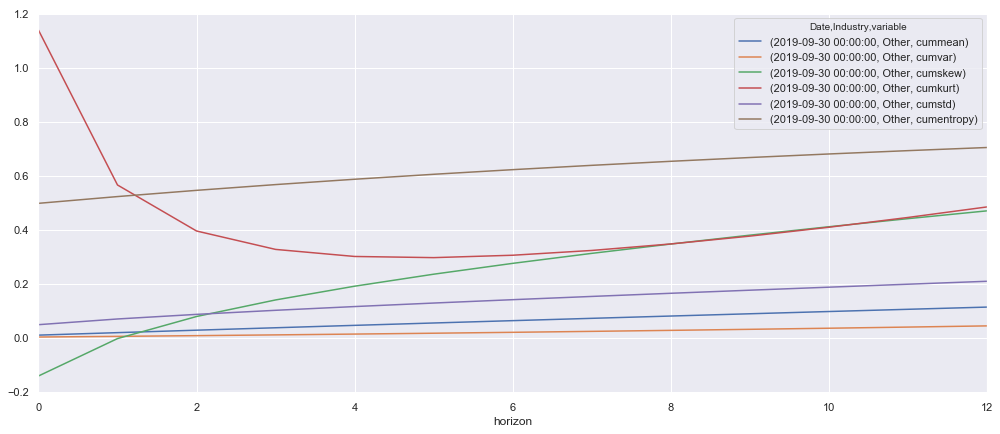

In [103]:
df_xs_predictions[hmm_name].iloc[-1:,:].T.unstack().iloc[:,-6:].plot(legend=True, figsize=[17,7])

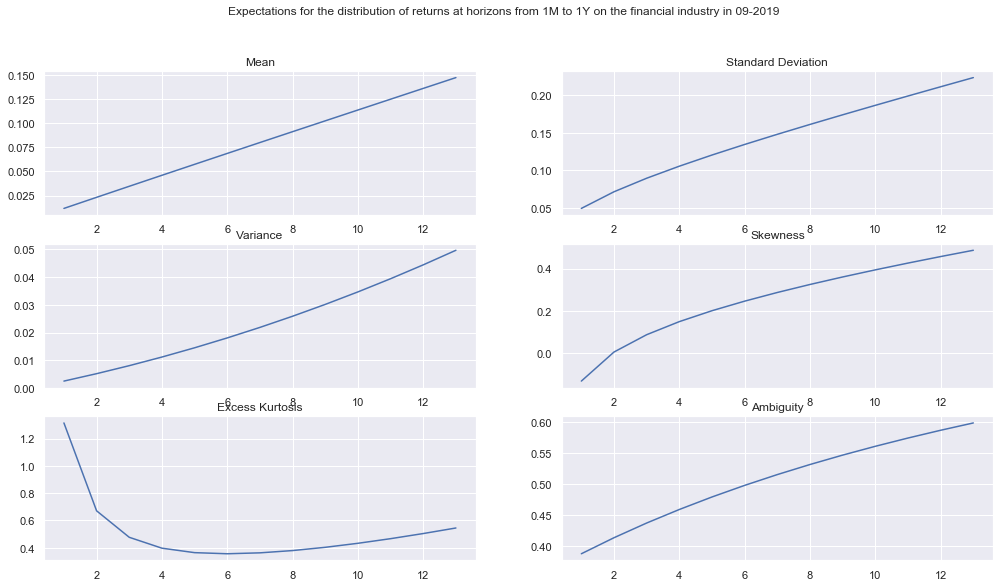

In [131]:
fig,axes = plt.subplots(3,2,figsize=[17,9])

fig.suptitle('Expectations for the distribution of returns at horizons from 1M to 1Y on the financial industry in 09-2019')

ax=axes[0,0]
ax.plot(df_xs_predictions.iloc[-2:-1,:].T.unstack().iloc[:,-6:-5].values)
ax.set_title('Mean')

ax=axes[0,1]
ax.plot(df_xs_predictions.iloc[-2:-1,:].T.unstack().iloc[:,-2:-1].values)
ax.set_title('Standard Deviation')

ax=axes[1,0]
ax.plot(df_xs_predictions.iloc[-2:-1,:].T.unstack().iloc[:,-5:-4].values)
ax.set_title('Variance')

ax=axes[1,1]
ax.plot(df_xs_predictions.iloc[-2:-1,:].T.unstack().iloc[:,-4:-3].values)
ax.set_title('Skewness')

ax=axes[2,0]
ax.plot(df_xs_predictions.iloc[-2:-1,:].T.unstack().iloc[:,-3:-2].values)
ax.set_title('Excess Kurtosis')

ax=axes[2,1]
ax.plot(df_xs_predictions.iloc[-2:-1,:].T.unstack().iloc[:,-1:].values)
ax.set_title('Ambiguity')

plt.show()

fig.savefig('momentTermStructurePlots.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Summary

In [103]:
h=11

In [104]:
x_axis_lim = [-0.2,0.2]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


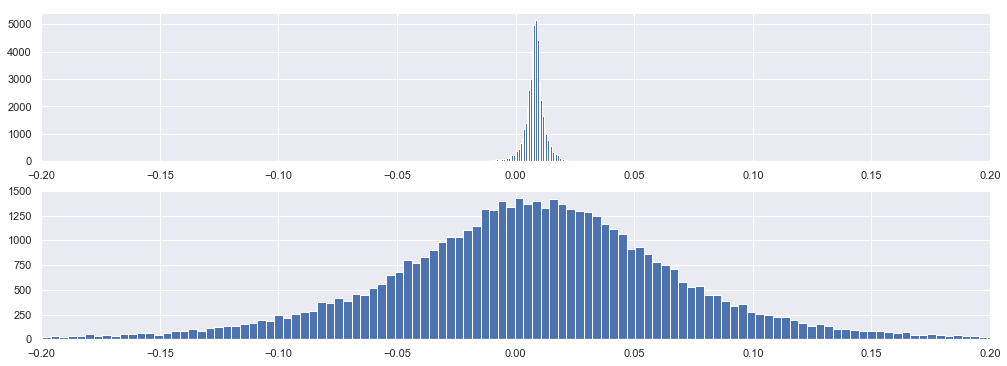

In [105]:
fig, ax = plt.subplots(2,1, figsize=[17,6])

ax[0].set_xlim(x_axis_lim)
ax[0].hist(df_xs_predictions[(h,'mean')], bins=100)

ax[1].set_xlim(x_axis_lim)
ax[1].hist(df_xs_predictions[('data','return')].shift(h), bins=1000)

plt.show()

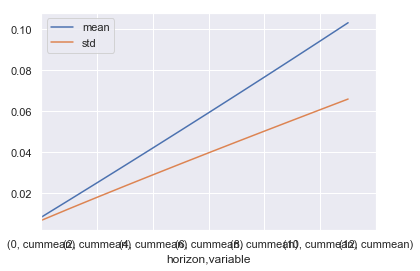

In [72]:
df_xs_predictions.T[df_xs_predictions.columns.get_level_values('variable')=='cumentropy'].T.describe().loc[['mean','std']].T.plot()